In [1]:
import tifffile
import numpy as np
from matplotlib import pyplot as plt
import os
import napari
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit
from scipy.ndimage import zoom
from napari.utils.notifications import show_info
from natsort import os_sorted
import tkinter
from tkinter import filedialog
from scipy import ndimage
import cv2
from scipy.ndimage import gaussian_filter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle
import json

In [5]:
def fwhm_along_axis(y, spacing, plot = False):
    # Maximum normalization
    y_norm = [i/max(y) for i in y]
    # create x values for plot based on the intensity values y considering the spacing
    x = [(i) * spacing for i in range(len(y_norm))]

    # find fwhm of plot
    spline = UnivariateSpline(x, y_norm-np.max(y_norm)/2, s=0)
    r1, r2 = spline.roots()
    fwhm = abs(abs(r1) - abs(r2))

    # return fwhm
    return [fwhm]


def get_fwhm(bbox, spacing_xy, spacing_z):
    # find max intensity
    max_coor = np.unravel_index(np.argmax(bbox), bbox.shape)
    xy_maxint = np.max(bbox, axis=0)
    xz_maxint = np.max(bbox, axis=1)
    # get intensity lines
    y_line = xy_maxint[int(max_coor[1]),:]
    x_line = xy_maxint[:,int(max_coor[2])]
    z_line = xz_maxint[:,int(max_coor[2])]
    # get fwhm
    fwhm_x = fwhm_along_axis(x_line, spacing_xy)
    fwhm_y = fwhm_along_axis(y_line, spacing_xy)
    fwhm_z = fwhm_along_axis(z_line, spacing_z)
    # return fwhm
    return [fwhm_x[0], fwhm_y[0], fwhm_z[0]], max_coor[0]
    

def apply_bbox_and_fwhm(img, psf, bbox_size = 10, spacing_xy = 0.06484, spacing_z = 0.06484):
    
    # make bounding box
    upper = [int(psf[0] + bbox_size/2), int(psf[1] + bbox_size/2)]
    lower = [int(psf[0] - bbox_size/2), int(psf[1] - bbox_size/2)]
    bbox = img[:,lower[0]:upper[0], lower[1]:upper[1]]
    fwhm_list, coor_z = get_fwhm(bbox, spacing_xy, spacing_z)
    
    return np.array(fwhm_list)*1000, coor_z

# extracting all the beads
def connected_component_analysis(stack, threshold = 10000):
    max_plane = np.max(stack, axis = 0)
    binary_mask = (max_plane >= threshold).astype(np.uint8)
    # connected component analysis
    labeled_mask, num_features = ndimage.label(binary_mask)
    centroids = ndimage.center_of_mass(binary_mask, labeled_mask, range(1, num_features + 1))

    return centroids

def load_datasets(paths):
    stacks = []
    for path in paths:
        stack = tifffile.imread(path)
        stacks.append(stack)
    return np.array(stacks)

def shift_stack_lateral(stack, xy_shift=(0,0)):
    rolled = np.roll(stack, xy_shift[0], axis=[0])
    shift = np.roll(rolled,xy_shift[1], axis=[1])   

def reshape_tiff_data(data, num_channels):
    # Initialize the output array with the desired shape (3, 250, 500, 500)
    zsteps = len(data)//num_channels
    output = np.zeros((num_channels, zsteps, data.shape[1], data.shape[2]), dtype=np.uint16)


    # Iterate over the z-steps
    for z in range(len(data)//num_channels):
        if z % 2 == 0:
            for c in range(num_channels):
                output[c, z] = data[z * num_channels + c]
        else:
            for c in range(num_channels):
                ci = num_channels - c - 1
                output[ci, z] = data[z * num_channels + c]

    return output

In [3]:
home = 'C:/Users/alm/Documents/ImSwitchConfig/recordings/2024-11-21/14h53m18s_rec_thorlabscam/'
files = os_sorted(os.listdir(home))
raw_stack =  np.array([tifffile.imread(home + file) for file in files if file.endswith('.tif')])

metadata_file = home + 'metadata.json'
metadata = json.load(open(metadata_file))
xy_pixel_size = metadata['detector_pixel_size']
z_spacing = metadata['sample_stage_step_size']

raw_stack = reshape_tiff_data(raw_stack, 2)[:,:,:]

# Detect PSFs automatically

In [6]:
# run PSF analysis on mf-sim PSF and widefield PSF detecting the PSFs automatically
from tqdm import tqdm
#TODO
channels = ['ex 488 em 525','ex 561 em 610']
if raw_stack.shape[0] == 1:
    raw_stack = np.repeat(raw_stack, 2, axis=0)
print(raw_stack.shape)
#raw_stack = raw_stack[:,:200,:,:]
stack = raw_stack[0]
wf_shift = raw_stack[1]
all_fwhm = []
all_fwhm_wf = []
points = []

for point in tqdm(connected_component_analysis(stack, threshold=220)):
    try:
        fwhm_xyz, coor_z = apply_bbox_and_fwhm(stack, point, bbox_size=20, spacing_xy=xy_pixel_size, spacing_z=z_spacing)
        fwhm_xyz_wf, coor_z_wf = apply_bbox_and_fwhm(wf_shift, point, bbox_size=20, spacing_xy=xy_pixel_size, spacing_z=z_spacing)
        all_fwhm.append(fwhm_xyz)
        all_fwhm_wf.append(fwhm_xyz_wf)
        points.append([coor_z, point[0], point[1]])
    except ValueError:
        continue

(2, 500, 2160, 4096)


100%|██████████| 17943/17943 [04:41<00:00, 63.80it/s] 


In [5]:
#viewer=napari.Viewer()
#viewer.add_image(stack, name='mf-sim')

In [7]:
ch1 = channels[0]
ch2 = channels[1]

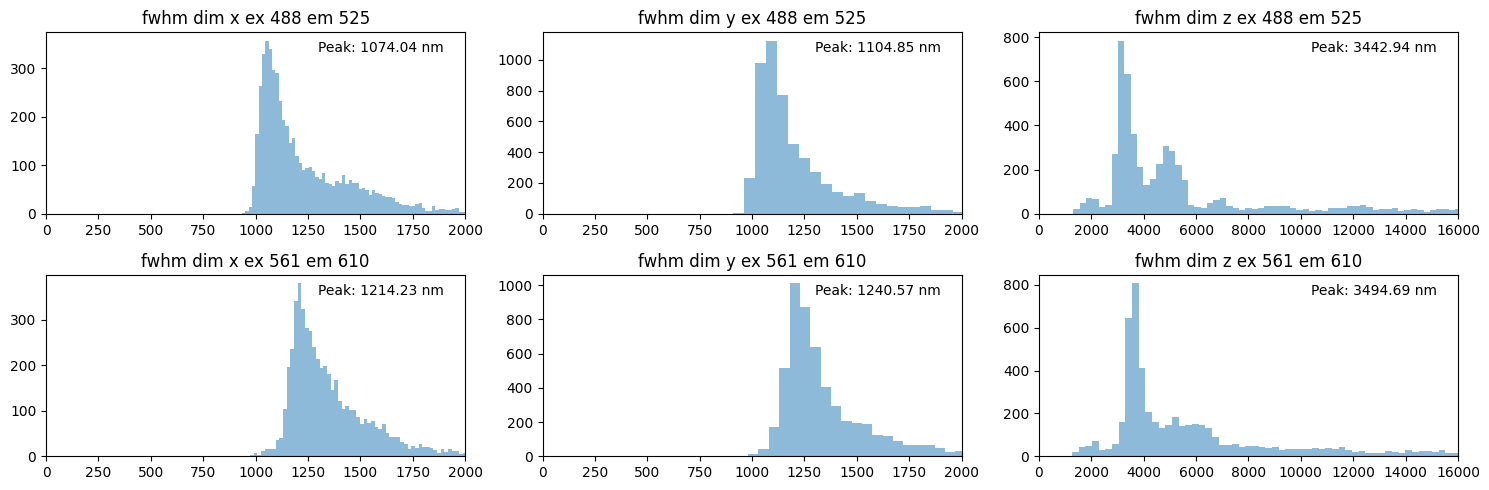

In [8]:
# plot histogram of fwhm values
all_fwhm = np.array(all_fwhm)
all_fwhm_wf = np.array(all_fwhm_wf)
bins = 100
# all_fwhm shape (3228, 3)
def add_peak_textbox(ax, data, bins=bins):
    hist, bin_edges = np.histogram(data, bins=40)  # Use the same number of bins as in the plot
    peak_bin_index = np.argmax(hist)
    peak_value = (bin_edges[peak_bin_index] + bin_edges[peak_bin_index + 1]) / 2  # Use the middle of the bin
    ax.text(0.95, 0.95, f'Peak: {peak_value:.2f} nm', 
            transform=ax.transAxes, 
            horizontalalignment='right', 
            verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

axes = ['x', 'y', 'z']
fig, axs = plt.subplots(2, 3, figsize=(15, 5))
for dims in range(all_fwhm.shape[1]):
    axs[0,dims].hist(all_fwhm[:,dims], bins=bins, alpha=0.5, label='ch1')
    axs[0,dims].set_title(f'fwhm dim {axes[dims]} '+ ch1)
    add_peak_textbox(axs[0, dims], all_fwhm[:, dims])
    axs[1,dims].hist(all_fwhm_wf[:,dims], bins=bins, alpha=0.5, label='ch2')
    axs[1,dims].set_title(f'fwhm dim {axes[dims]} '+ ch2)  
    add_peak_textbox(axs[1, dims], all_fwhm_wf[:, dims])
    if dims == 2:
        axs[0,dims].set_xlim(0,16000)
        axs[1,dims].set_xlim(0,16000)
    else:
        axs[0,dims].set_xlim(0,2000)
        axs[1,dims].set_xlim(0,2000)
plt.tight_layout()
plt.show()

In [8]:
viewer = napari.Viewer()
viewer.add_image(stack, name='mf-sim', scale=[z_spacing, xy_pixel_size, xy_pixel_size])
viewer.add_image(wf_shift, name='wf', scale=[z_spacing, xy_pixel_size, xy_pixel_size])

<Image layer 'wf' at 0x2a2eb068940>

In [9]:
# filter psfs
max_fwhm_x_plus_y = 15000
max_fwhm_z = 30000
min_fwhm_z = 2500

# run PSF analysis on mf-sim PSF and widefield PSF detecting the PSFs automatically
filtered_fwhm_ch1 = []
filtered_fwhm_ch2 = []
filtered_points = []
for i in range(len(points)):
    fwhm_x = all_fwhm[i, 0]
    fwhm_y = all_fwhm[i, 1]
    fwhm_z = all_fwhm[i, 2]
    fwhm_x_wf = all_fwhm_wf[i, 0]
    fwhm_y_wf = all_fwhm_wf[i, 1]
    fwhm_z_wf = all_fwhm_wf[i, 2]
    if fwhm_x + fwhm_y < max_fwhm_x_plus_y and fwhm_z < max_fwhm_z and fwhm_z > min_fwhm_z:
        filtered_fwhm_ch1.append([fwhm_x, fwhm_y, fwhm_z])
        filtered_fwhm_ch2.append([fwhm_x_wf, fwhm_y_wf, fwhm_z_wf])
        filtered_points.append(points[i])

filtered_fwhm_ch1 = np.array(filtered_fwhm_ch1)
avg = np.mean(filtered_fwhm_ch1, axis=0) 
sd = np.std(filtered_fwhm_ch1, axis=0) 
print('- ch0, Number of beads selected: {}'.format(filtered_fwhm_ch1.shape[0]))
print('- X FWHM is {:.4f} +/- {:4f} nm'.format(avg[1], sd[1]))
print('- Y FWHM is {:.4f} +/- {:4f} nm'.format(avg[0], sd[0]))
print('- Z FWHM is {:.4f} +/- {:4f} nm'.format(avg[2], sd[2]))

filtered_fwhm_ch2 = np.array(filtered_fwhm_ch2)
avg_wf = np.mean(filtered_fwhm_ch2, axis=0) 
sd_wf = np.std(filtered_fwhm_ch2, axis=0) 
print('- ch1, Number of beads selected: {}'.format(filtered_fwhm_ch2.shape[0]))
print('- X FWHM is {:.4f} +/- {:4f} nm'.format(avg_wf[1], sd_wf[1]))
print('- Y FWHM is {:.4f} +/- {:4f} nm'.format(avg_wf[0], sd_wf[0]))
print('- Z FWHM is {:.4f} +/- {:4f} nm'.format(avg_wf[2], sd_wf[2]))

# add psfs to napari
#viewer.add_points(points)

- ch0, Number of beads selected: 2534
- X FWHM is 1114.7358 +/- 76.052673 nm
- Y FWHM is 1126.8804 +/- 75.194071 nm
- Z FWHM is 5170.9443 +/- 2337.981597 nm
- ch1, Number of beads selected: 2534
- X FWHM is 1468.5455 +/- 185.071821 nm
- Y FWHM is 1502.4058 +/- 199.022763 nm
- Z FWHM is 7141.6735 +/- 3474.602683 nm


[[26, 46.707317073170735, 357.52682926829266], [8, 47.03846153846154, 2277.641025641026], [18, 56.739583333333336, 1768.7291666666667], [8, 50.0, 2282.0], [18, 52.0, 1764.0], [12, 55.03448275862069, 2378.5172413793102], [12, 59.15294117647059, 3304.247058823529], [26, 55.0, 352.5], [18, 56.0, 1775.0], [18, 57.0, 1776.0], [18, 59.0, 1775.0], [20, 65.43820224719101, 1897.2247191011236], [18, 64.0, 1764.0], [20, 65.0, 1891.0], [20, 65.0, 1904.0], [20, 66.0, 1890.0], [25, 74.70625, 1075.05625], [20, 71.0, 1891.0], [20, 73.0, 1896.0], [25, 79.5, 1081.0], [25, 80.0, 1071.0], [25, 80.0, 1083.0], [25, 81.0, 1072.0], [8, 97.58823529411765, 3002.6470588235293], [8, 96.0, 2779.0], [8, 96.0, 2781.0], [8, 97.0, 2776.0], [8, 100.7, 2778.1], [16, 118.07042253521126, 717.5352112676056], [16, 114.0, 720.5], [16, 114.0, 723.0], [16, 115.0, 722.0], [16, 115.0, 724.5], [12, 124.9342105263158, 2394.3026315789475], [16, 121.0, 723.5], [16, 122.0, 722.0], [12, 122.0, 2389.0], [10, 126.67105263157895, 3746.78

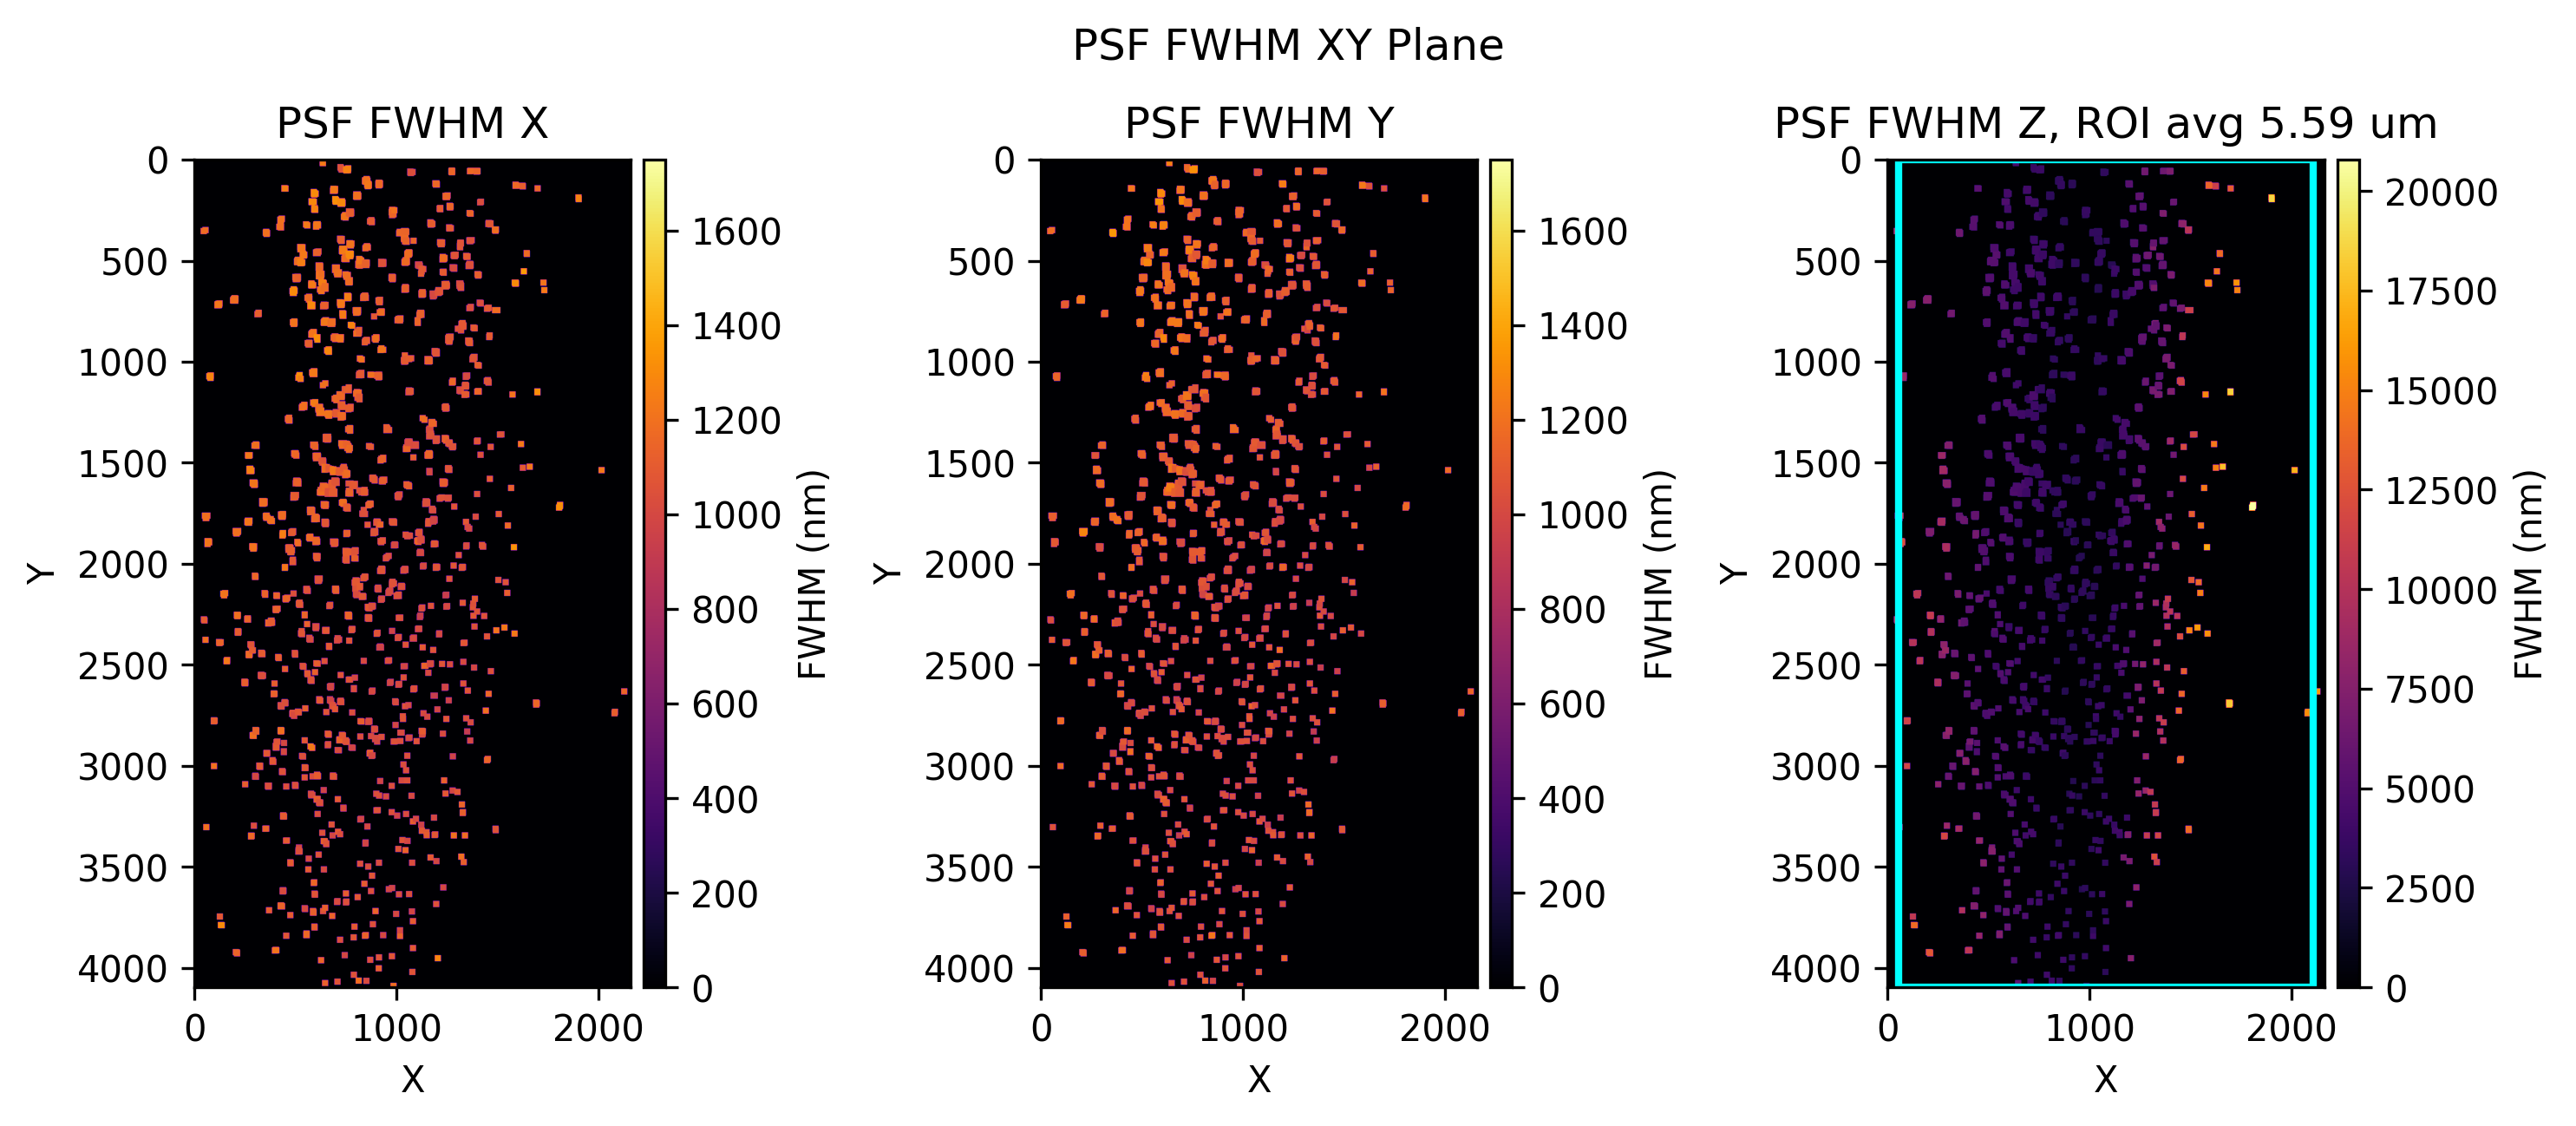

In [13]:
print(filtered_points)
z = [i[0] for i in filtered_points]
y = [i[1] for i in filtered_points]
x = [i[2] for i in filtered_points]
import scipy

def add_square(grid, x, y, value, size=30):
    x_start = max(0, x - size // 2)
    x_end = min(grid.shape[1], x + size // 2 + 1)
    y_start = max(0, y - size // 2)
    y_end = min(grid.shape[0], y + size // 2 + 1)
    grid[y_start:y_end, x_start:x_end] = value

z_max, y_max, x_max = stack.shape       #300 2160 4096

def plot(x, y, x_shape, y_shape, all_fwhm, title='psf',ytitle=0.63, ROI_scale=None, xshift=0, spotsize=30, scale_x = 1):

    fig, axs = plt.subplots(1, 3, figsize=(10, 15), dpi=300)
    fig.suptitle(title, y=ytitle)
    dim = ['X', 'Y', 'Z']
    for dims in range(all_fwhm.shape[1]):
        grid = np.zeros((x_shape, y_shape))
        for i in range(len(x)):
            add_square(grid, int(x[i]), int(y[i]), all_fwhm[i, dims], size=spotsize)
        scaled_grid = scipy.ndimage.zoom(grid, (1, scale_x), order=1)
        if dims < 2:
            im = axs[dims].imshow(scaled_grid, cmap='inferno', vmin=0, vmax=1750)#, origin='lower', extent=[0.5, x_max+0.5, 0.5, y_max+0.5])
        else:
            im = axs[dims].imshow(scaled_grid, cmap='inferno')
        axs[dims].set_xlabel('X')
        axs[dims].set_ylabel('Y')
        divider = make_axes_locatable(axs[dims])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax, label='FWHM (nm)')
        if dims == 2 and ROI_scale!=None:   
            xy_tuple = (int(y_shape*0.5)-int((y_shape*ROI_scale)/2) + xshift,0)
            roi_values = grid[0:x_shape,xy_tuple[0]:xy_tuple[0]+int(y_shape*ROI_scale)]
            non_zero_values = roi_values[roi_values > 0]

            if len(non_zero_values) > 0:
                roi_average = np.mean(non_zero_values)
            else:
                roi_average = 0  
            axs[dims].set_title(f'PSF FWHM {dim[dims]}, ROI avg {(roi_average/1000):.2f} um')
            print(f'Axial PSF within ROI: {roi_average}, ROI shape: {roi_values.shape}')
            rect = Rectangle(xy_tuple, int(y_shape*ROI_scale), x_shape,
                             linewidth=2, edgecolor='cyan', facecolor='none')
            axs[dims].add_patch(rect)
        else:
            axs[dims].set_title('PSF FWHM ' + dim[dims])
    fig.tight_layout()
    plt.show()


plot(y,x,x_max, y_max, filtered_fwhm_ch1, title='PSF FWHM XY Plane', ytitle=0.63, ROI_scale=0.95, xshift=0)

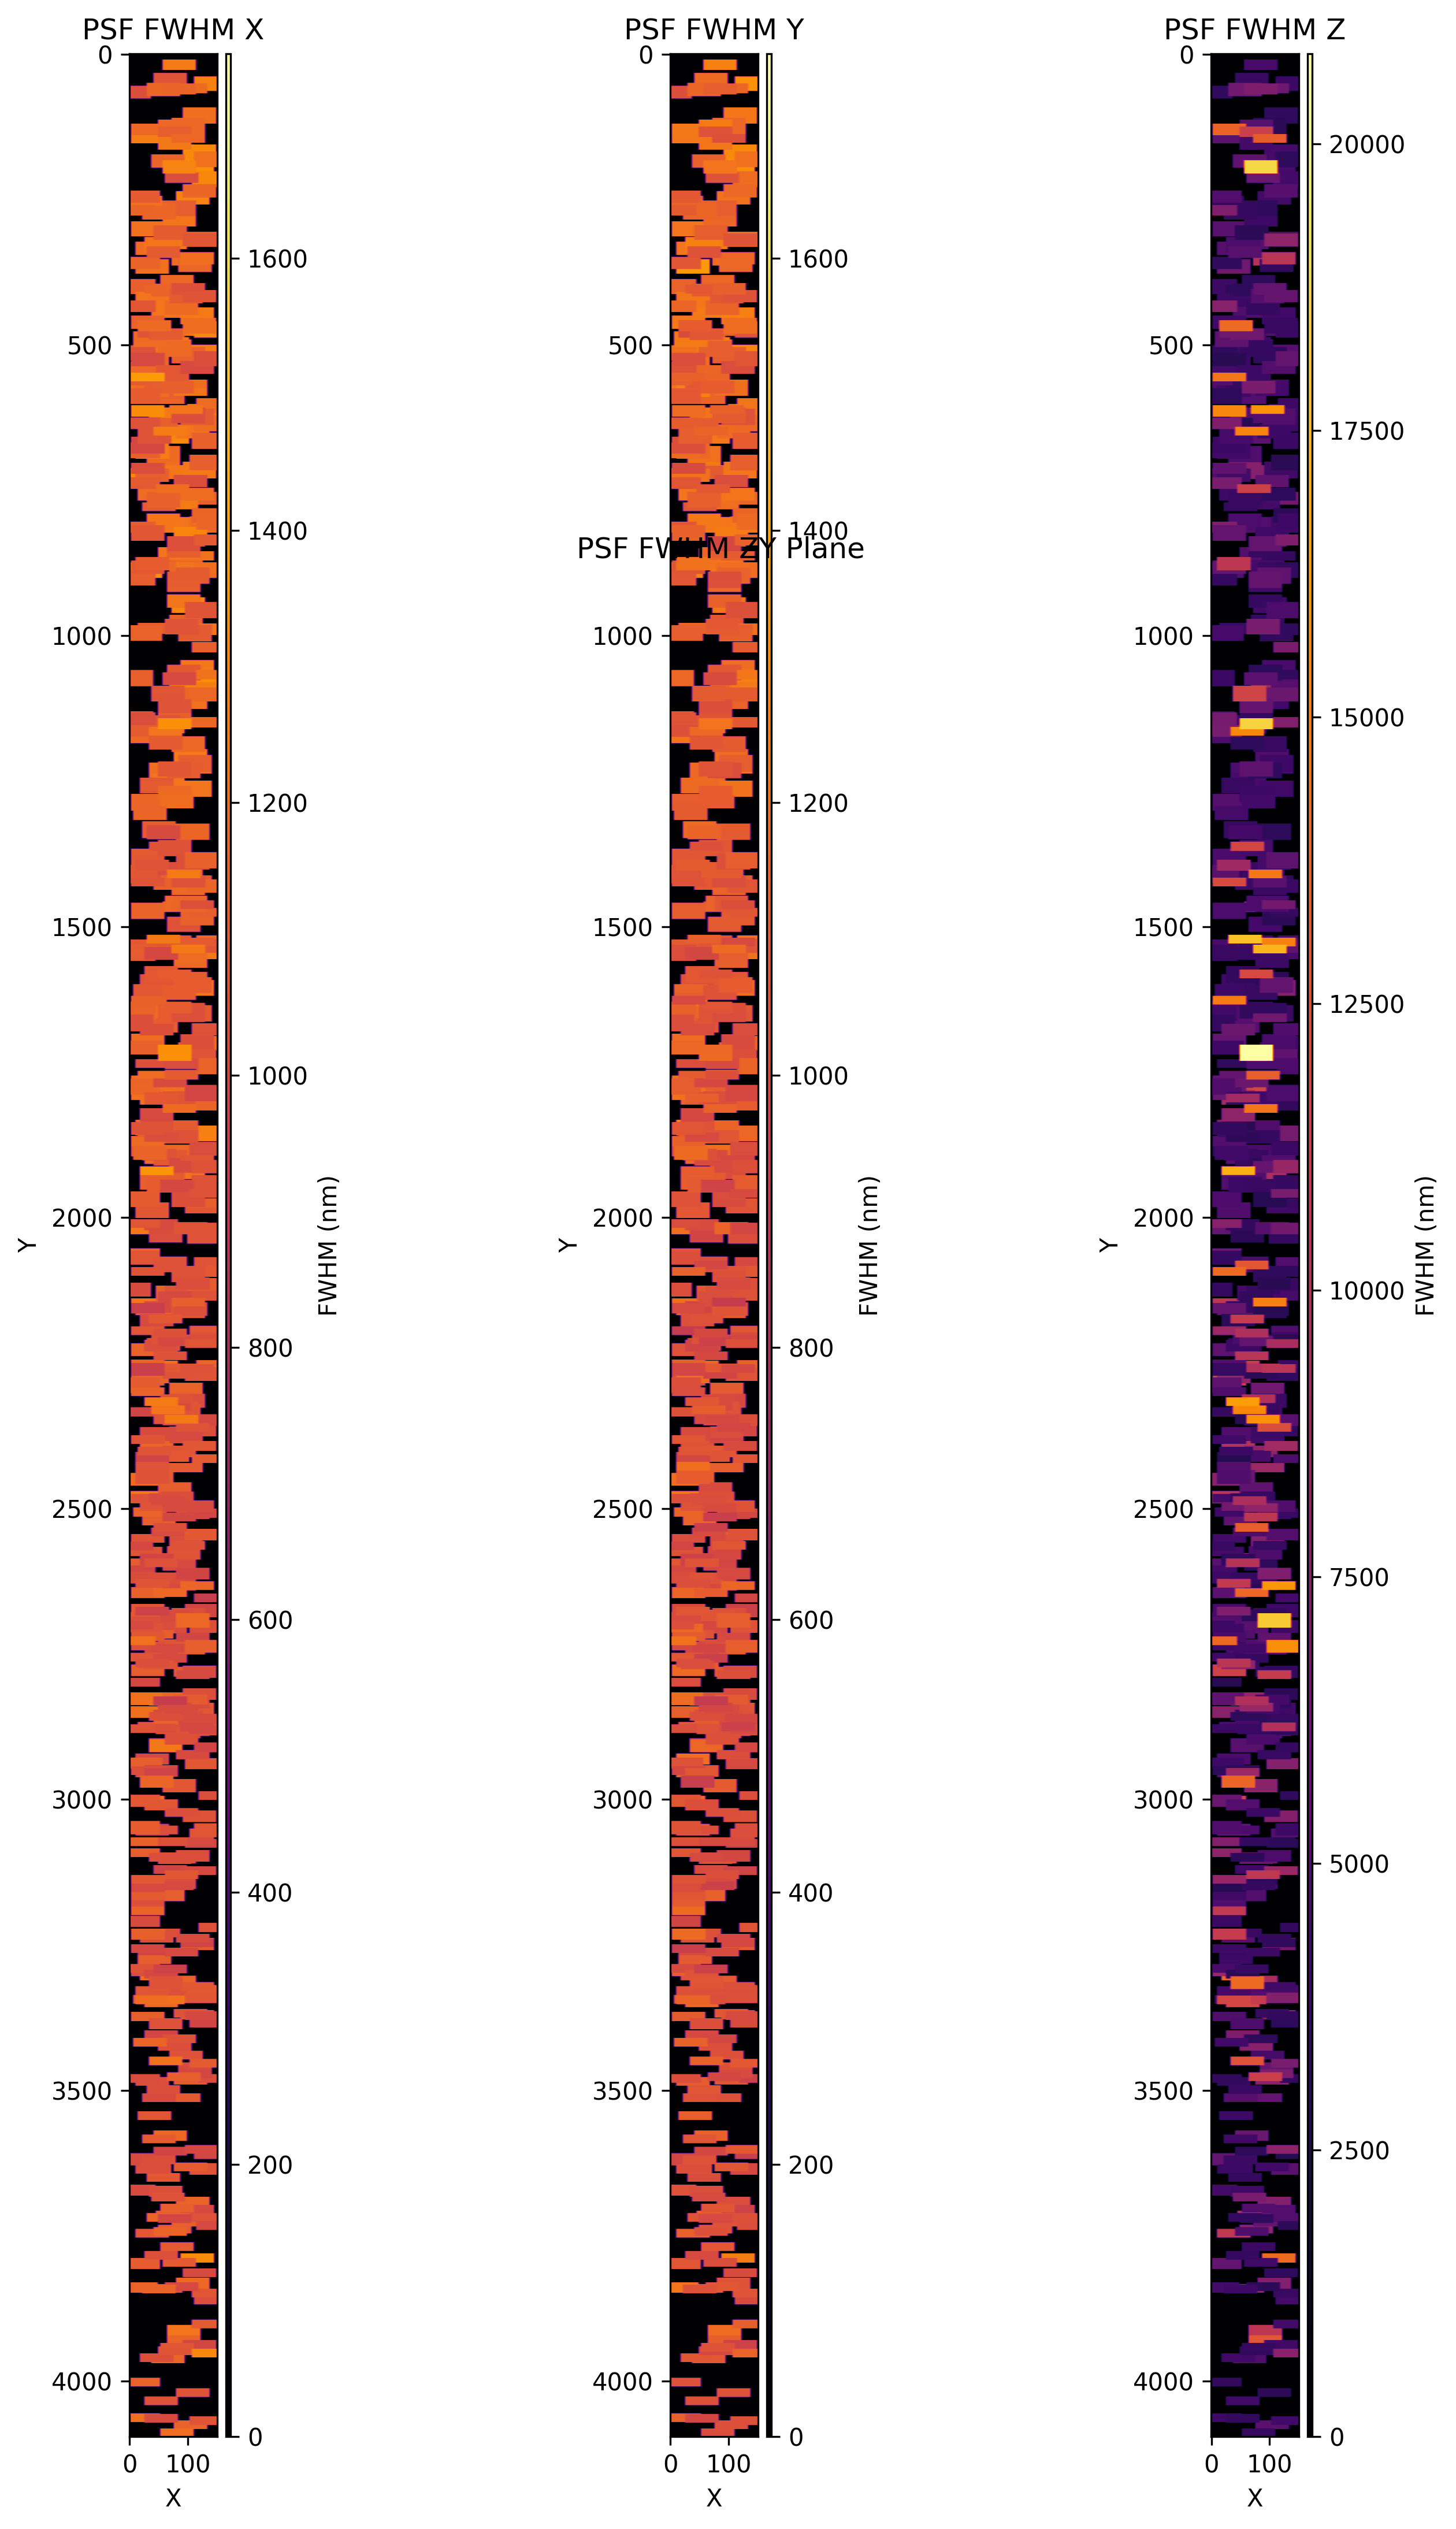

In [11]:
plot(z,x,x_max, z_max, filtered_fwhm_ch1, title='PSF FWHM ZY Plane', ytitle=0.77, spotsize = 15, scale_x=(z_spacing/xy_pixel_size))#, ROI_scale=0.4, xshift=180)

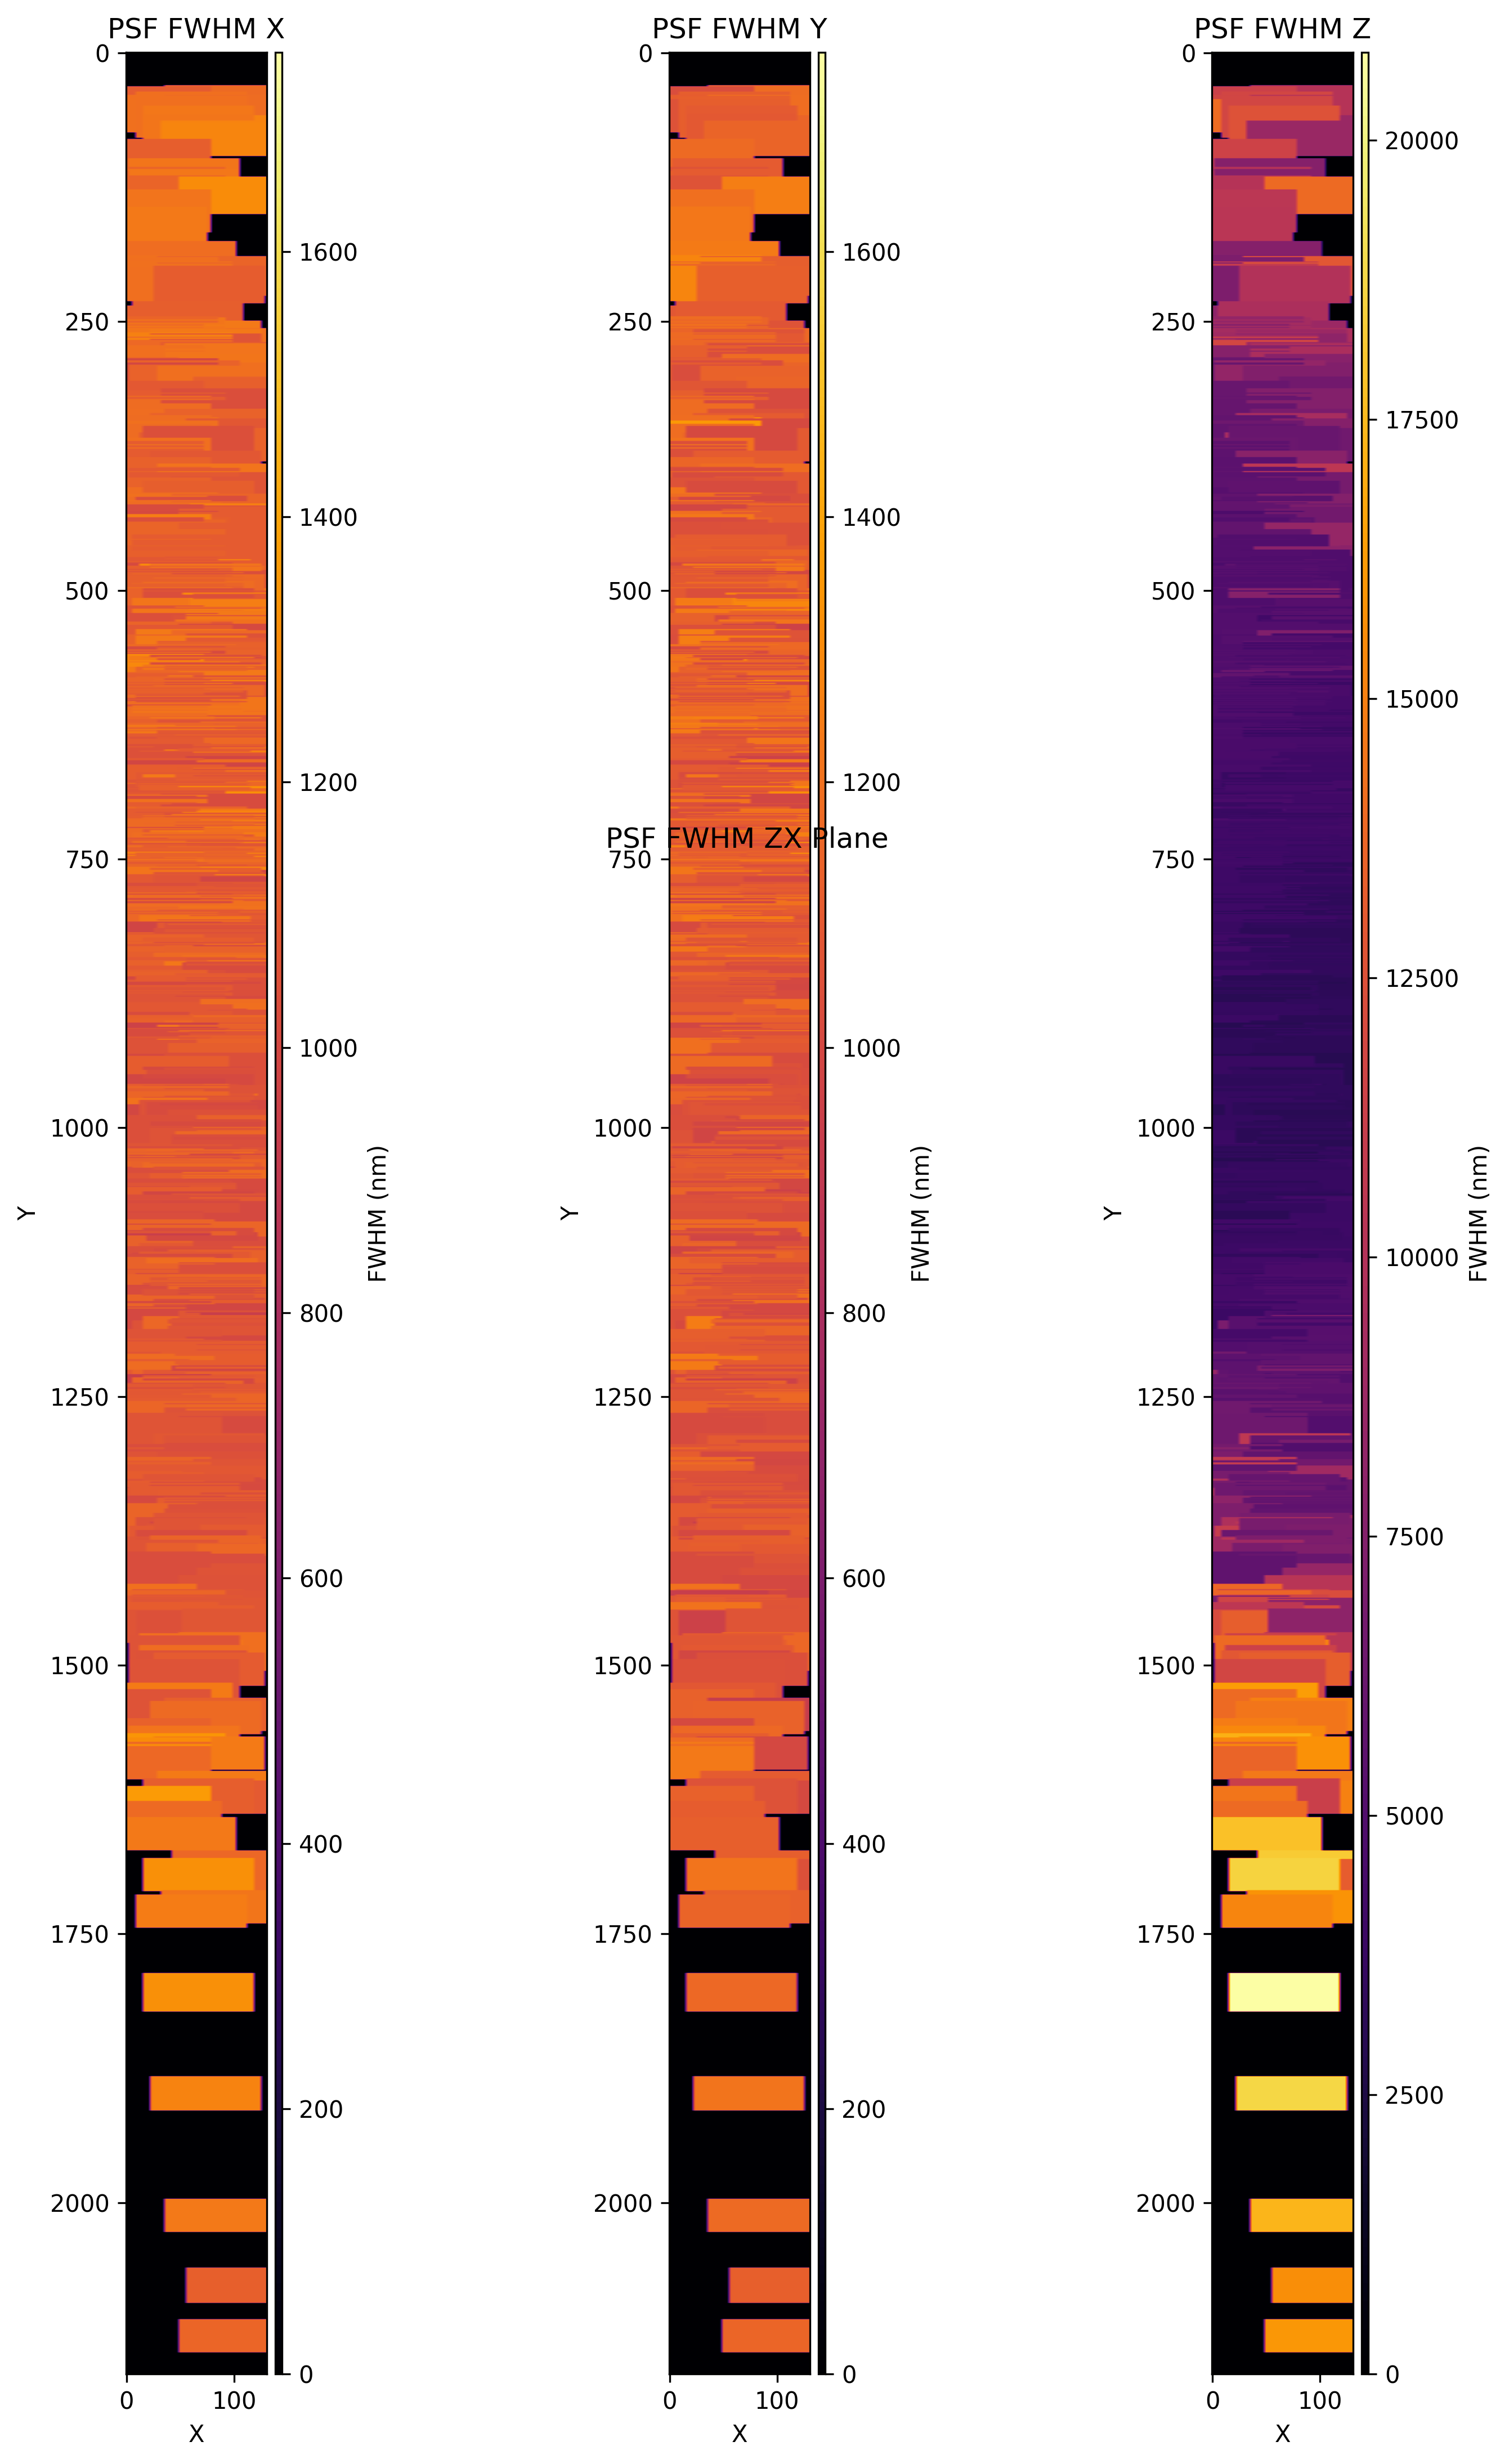

In [12]:
plot(z,y,y_max, z_max, filtered_fwhm_ch1, title='PSF FWHM ZX Plane', ytitle=0.65, scale_x=(1.1261/0.345))#, ROI_scale=0.4, xshift=180)
    